<a href="https://colab.research.google.com/github/Rogerio-mack/Research-Literature-Review-APIs/blob/main/search_semanticscholar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Literature review from [Semanticscholar](https://www.semanticscholar.org)

**`keyword`** = 'supply chain resilience'

In [ ]:
#@markdown Setups
keyword = 'supply chain resilience'
max_search = 5000 # total search
limit = 100 # each search, max is 100 from api documentation!
api_search = 'https://api.semanticscholar.org/graph/v1/paper/search?query='
print_json = False
include_authors = True # in this case, set field author 

# Fields
fields = (
'paperId,' # - Always included
# 'externalIds,'
# 'url,'
'title,' # - Included if no fields are specified 
'abstract,'
# 'venue,'
'year,'
# 'referenceCount,'
'citationCount,'
'influentialCitationCount,'
# 'isOpenAccess,'
# 'fieldsOfStudy,'
'authors,' # - Up to 500 will be returned 
##    'authorId,' #  - Always included 
##    'name,' # - Always included'
)

fields = fields[0:-1] # exclude last comma

print('Fields extracted: ', fields)

Fields extracted:  paperId,title,abstract,year,citationCount,influentialCitationCount,authors


In [ ]:
#@markdown Check if Exist Articles
import requests  # Import the requests library
import json
import pandas as pd
import pprint # nicely json print
import time

# Query URL
# url = ('https://api.semanticscholar.org/graph/v1/paper/search?query=supply chain resilience&offset=0&limit=4&fields=title,year')

url = api_search + keyword + '&fields=' + fields + '&limit=' + str(limit) + '&offset=' # without offset value here
print(url + str(0))

url_qty = api_search + keyword + '&fields=' + fields + '&limit=' + str(1) + '&offset=' + str(0)

response = requests.get(url_qty)  # Make a GET request to the URL
payload = response.json()  # Parse `response.text` into JSON

print(f"Request returned {response.status_code} : '{response.reason}'")

if (payload['total'] > 0):
  print(f"Total of keyword search results: {payload['total']}")
  max = min(max_search,payload['total'])
  print()
else:
  print(f"No results for  keyword search: {keyword}")
  print()  

    

https://api.semanticscholar.org/graph/v1/paper/search?query=supply chain resilience&fields=paperId,title,abstract,year,citationCount,influentialCitationCount,authors&limit=100&offset=0
Request returned 200 : 'OK'
Total of keyword search results: 225418



In [ ]:
#@markdown Populate local Database
from pandas.core.arrays import integer
url = api_search + keyword + '&fields=' + fields + '&limit=' + str(limit) + '&offset=' # without offset value here
print(url + str(0))

all_items = []

for offset in range(0, max, limit):
  response = requests.get(url + str(offset))  # Make a GET request to the URL
  # print(url + str(offset))
  # print(offset)
  # Print data returned (parsing as JSON)
  payload = response.json()  # Parse `response.text` into JSON

  if response.status_code != 200 or print_json == True: 
    print(f"Request returned {response.status_code} : '{response.reason}'")
    pp = pprint.PrettyPrinter(indent=1)
    pp.pprint(payload)
    # NOTE: Could use print(response.json()) but this wouldn't be formatted nicely

  # print(len(payload['data']))
  all_items.append(payload)    

  if (offset+1)%(limit * 10) == 0: # wait each 10 searchs to avoid forbiden access (443)
    time.sleep(5) # Sleep for 5 seconds

# Normalizing data
df = pd.json_normalize(all_items[0], record_path =['data'])

for i in range(1,len(all_items)):
  df = pd.concat([df, pd.json_normalize(all_items[i], record_path =['data'])])

df = df.reset_index(drop=True)

if include_authors:
  first_authors = []
  all_authors = []

  for i in range(len(all_items)):
    for j in range(len(all_items[i]['data'])):
      authors = []
      for k in range(len(all_items[i]['data'][j]['authors'])):
        authors.append(all_items[i]['data'][j]['authors'][k]['name'])
      all_authors.append(str(authors))
      if len(authors) != 0:
        if len(authors) > 1:
          first_authors.append(str(authors[0]) + ', et. al.')
        else:
          first_authors.append(str(authors[0]))
      else:
        first_authors.append('None')
  
  df['first_author'] = first_authors
  df['authors'] = all_authors
  
  df['authors'] = df['authors'].str.replace('[','',regex=False)
  df['authors'] = df['authors'].str.replace(']','',regex=False)
  df['authors'] = df['authors'].str.replace('\'','',regex=False)

df.year = df.year.fillna(1900)
df.year = df.year.astype('int')

df.abstract = df.abstract.fillna('None')

df = df.drop_duplicates()
df = df.reset_index(drop=True)

print('SUMMARY SEARCH')
print(100*'-')
print(' Base: ', api_search)
print(' keyword: ', keyword)
print(' Fields: ',fields)
print()
print('RESULTS')
print(100*'-')

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

display(df[['title', 'year', 'first_author', 'authors', 'citationCount', 'influentialCitationCount']].head()) # by relevance
# display(df[['title', 'year', 'authors', 'citationCount', 'influentialCitationCount']].sort_values('citationCount',ascending=False))

https://api.semanticscholar.org/graph/v1/paper/search?query=supply chain resilience&fields=paperId,title,abstract,year,citationCount,influentialCitationCount,authors&limit=100&offset=0
SUMMARY SEARCH
----------------------------------------------------------------------------------------------------
 Base:  https://api.semanticscholar.org/graph/v1/paper/search?query=
 keyword:  supply chain resilience
 Fields:  paperId,title,abstract,year,citationCount,influentialCitationCount,authors

RESULTS
----------------------------------------------------------------------------------------------------


,title,year,first_author,authors,citationCount,influentialCitationCount
0,Empirical investigation of data analytics capability and organizational flexibility as complemen...,2019,"Rameshwar Dubey, et. al.","Rameshwar Dubey, A. Gunasekaran, S. Childe, S. Wamba, D. Roubaud, Cyril R. H. Foropon",176,6
1,Manufacturing and service supply chain resilience to the COVID-19 outbreak: Lessons learned from...,2020,"Amine Belhadi, et. al.","Amine Belhadi, Sachin S. Kamble, C. Jabbour, A. Gunasekaran, N. Ndubisi, Mani Venkatesh",105,6
2,Food supply chain resilience and the COVID‐19 pandemic: What have we learned?,2021,J. Hobbs,J. Hobbs,17,0
3,Artificial intelligence-driven innovation for enhancing supply chain resilience and performance ...,2021,"Amine Belhadi, et. al.","Amine Belhadi, V. Mani, Sachin S. Kamble, S. A. R. Khan, Surabhi Verma",14,0
4,Viability of intertwined supply networks: extending the supply chain resilience angles towards s...,2020,"D. Ivanov, et. al.","D. Ivanov, A. Dolgui",422,18


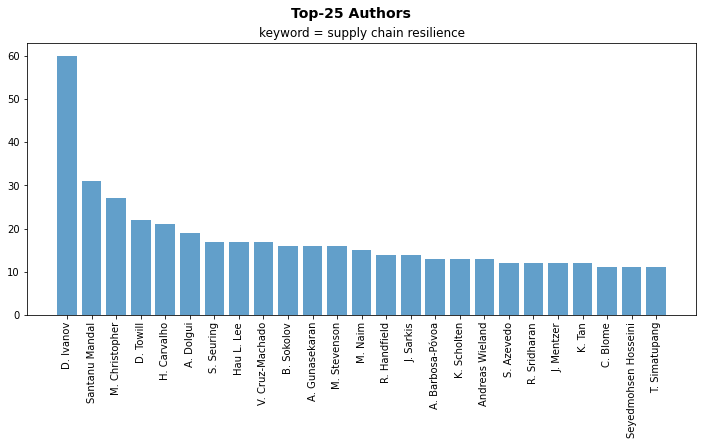

In [ ]:
#@markdown  
import matplotlib.pyplot as plt
%matplotlib inline

authors_dic = {}
for authors in df['authors']:
  authors_list = authors.split(',')
  for author in authors_list:
    a = author.lstrip().rstrip() # remove white spaces before and after
    if a not in authors_dic.keys():    
      authors_dic[a] = 1                    
    else:                                  
      authors_dic[a] =  authors_dic[a] + 1

# print(list(authors_dic.items())[:10])   

df_authors_count = pd.DataFrame(authors_dic.items(),  columns=['author', 'count']).sort_values('count',ascending=False)
df_authors_count = df_authors_count.sort_values('count',ascending=False)
df_authors_count = df_authors_count.reset_index(drop=True)
# df_authors_count.head()

df_authors_count = df_authors_count[df_authors_count.author != ''] # clear articles without authors!

df_authors_count = df_authors_count.head(25)

plt.figure(figsize=(12,5))
plt.bar(x=df_authors_count['author'], height=df_authors_count['count'],alpha=0.7)

plt.suptitle('Top-25 Authors', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.xticks(rotation=90)
plt.show()



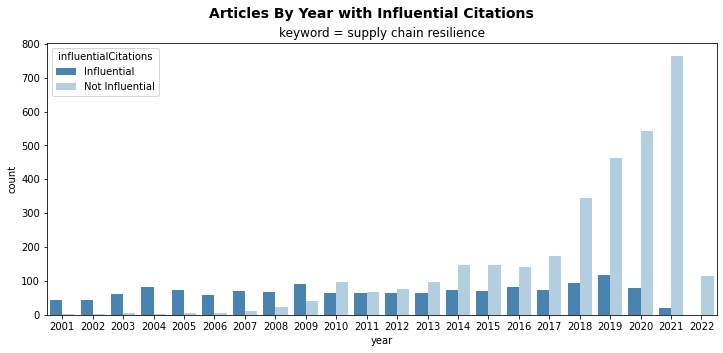

In [ ]:
#@markdown  
import seaborn as sns

df_2000 = df[ df.year > 2000 ].copy()
df_2000['influentialCitations'] = df.influentialCitationCount > 0
df_2000['influentialCitations'] = df_2000['influentialCitations'].replace(True, 'Influential')
df_2000['influentialCitations'] = df_2000['influentialCitations'].replace(False, 'Not Influential')

plt.figure(figsize=(12,5))
sns.countplot(x='year', hue='influentialCitations', data=df_2000, palette=sns.color_palette("Blues_r",2))

plt.suptitle('Articles By Year with Influential Citations', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()


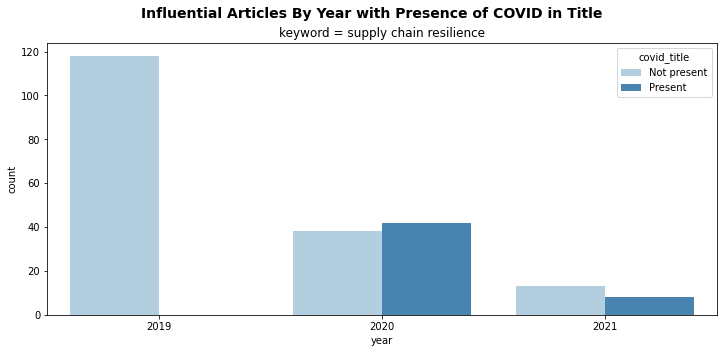

In [ ]:
#@markdown  
df_covid = df_2000[ (df_2000.year >= 2019) & (df_2000['influentialCitations'] == 'Influential') ].copy() 

df_covid['covid_title'] = df_covid['title'].str.lower().str.count('covid') > 0
df_covid['covid_title'] = df_covid['covid_title'].replace(True, 'Present')
df_covid['covid_title'] = df_covid['covid_title'].replace(False, 'Not present')

plt.figure(figsize=(12,5))
sns.countplot(x='year', hue='covid_title', data=df_covid, palette=sns.color_palette("Blues",2))

plt.suptitle('Influential Articles By Year with Presence of COVID in Title', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()

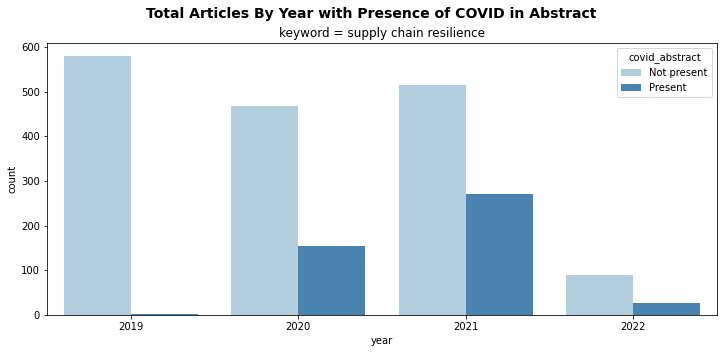

In [ ]:
#@markdown  
df_covid_abstract = df_2000[ (df_2000.year >= 2019) ].copy() 

df_covid_abstract['covid_abstract'] = df_covid_abstract['abstract'].str.lower().str.count('covid') > 0
df_covid_abstract['covid_abstract'] = df_covid_abstract['covid_abstract'].replace(True, 'Present')
df_covid_abstract['covid_abstract'] = df_covid_abstract['covid_abstract'].replace(False, 'Not present')

plt.figure(figsize=(12,5))
sns.countplot(x='year', hue='covid_abstract', data=df_covid_abstract, palette=sns.color_palette("Blues",2))

plt.suptitle('Total Articles By Year with Presence of COVID in Abstract', fontsize=14, weight='bold')
plt.title('keyword = ' + keyword, fontsize=12)
plt.show()

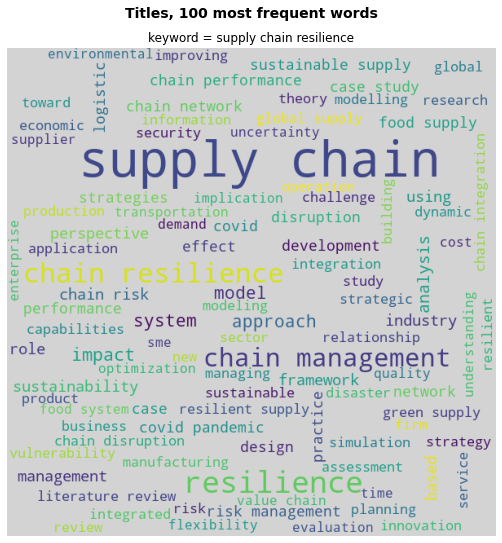

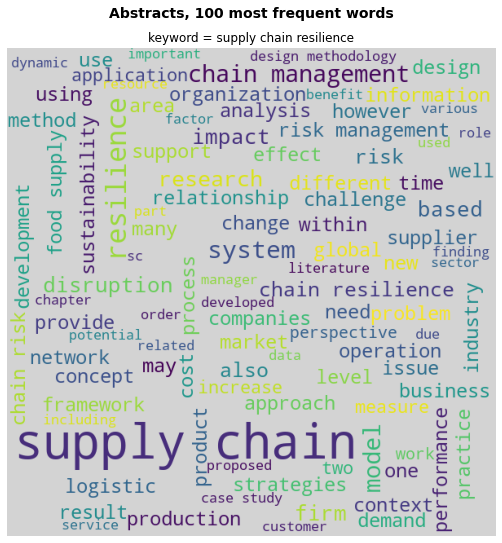

In [ ]:
#@markdown 
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def word_cloud(df,df_column,plot_title='Word Cloud',limit=100):

  stopwords_set = set( stopwords.words('english'))

  texto_string = ''
  for texto in df[df_column]:
    texto_string = texto_string + ' ' + texto.lower()  

  wordcloud = WordCloud(width = 600, height = 600,
          background_color ='lightgrey',
          max_words=limit,
          stopwords = stopwords_set,
          min_font_size = 10).generate(texto_string)

  print('\n')
  plt.figure(figsize = (7, 7), facecolor = None)
  plt.suptitle(plot_title, fontsize=14, weight='bold', y=1.05)
  plt.title('keyword = ' + keyword, fontsize=12)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

  return

word_cloud(df,'title',plot_title='Titles, 100 most frequent words')
word_cloud(df,'abstract',plot_title='Abstracts, 100 most frequent words')

